**Proyecto Detección de accidentes automovilísticos**

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [0]:
## ------------------------------- MODELO VGG16 SIN MODIFICACIONES  ------------------------------- 

modeloVGG16 = tf.keras.applications.VGG16(weights="imagenet")
modeloVGG16.summary()

553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [0]:
# ----------------------- CARGA DEL DATASET ---------------------
import gc
from os import scandir, getcwd
from os.path import abspath

#Función para listar archivos 
def listarArchivos(ruta = getcwd()):
    return [abspath(arch.path) for arch in scandir(ruta) if arch.is_file()]

def cargaImage(i):
  img1 = tf.keras.preprocessing.image.load_img(i, target_size=(224, 224))
  imgPre = tf.keras.preprocessing.image.img_to_array(img1)
  return imgPre

gc.collect()




x_train_Accidente = [ cargaImage(i) 
                    for i in listarArchivos("/content/drive/My Drive/Colab Notebooks/Proyecto/xEntrenamientoAccidente/img/") ]

In [0]:
x_train_NoAccidente = [ cargaImage(i) 
                      for i in listarArchivos("/content/drive/My Drive/Colab Notebooks/Proyecto/xEntrenamientoNoAccidente/img/") ]

In [0]:
x_Test_Accidente = [ cargaImage(i) 
                      for i in listarArchivos("/content/drive/My Drive/Colab Notebooks/Proyecto/xPruebaAccidente/img/") ]

In [0]:
x_Test_NoAccidente = [ cargaImage(i) 
                      for i in listarArchivos("/content/drive/My Drive/Colab Notebooks/Proyecto/xPruebaNoAccidente/img/") ]

In [0]:
# Generando las etiquetas para cada conjunto de datos --------------------------- --------------------------- 

y_train_Accidente = [1 for _ in range(len(x_train_Accidente))]
y_train_NoAccidente = [ 0 for _ in range(len(x_train_NoAccidente)) ]

y_test_Accidente = [1 for _ in range(len(x_Test_Accidente))]
y_test_NoAccidente = [0 for _ in range(len(x_Test_NoAccidente))]


print (len(y_train_Accidente), len(y_train_NoAccidente), len(y_test_Accidente), len(y_test_NoAccidente))
print ( len(x_train_Accidente), len(x_train_NoAccidente), len(x_Test_Accidente), len(x_Test_NoAccidente))

1042 1042 1084 1084
1042 1042 1084 1084


In [0]:
gc.collect()

0

In [0]:
# Concatenando los X de entrenamiento y prueba para generar un mismo conjunto de datos --------------------------- --------------------------- 
x_train_Accidente = np.array(x_train_Accidente)
x_train_NoAccidente = np.array(x_train_NoAccidente)

x_test_Accidente = np.array(x_Test_Accidente)
x_test_NoAccidente = np.array(x_Test_NoAccidente)

y_train_Accidente = np.array(y_train_Accidente)
y_train_NoAccidente = np.array(y_train_NoAccidente)

y_test_Accidente = np.array(y_test_Accidente)
y_test_NoAccidente = np.array(y_test_NoAccidente)

# -----------------------------

X_train = np.concatenate( (x_train_NoAccidente, x_train_Accidente), axis = 0 )
X_test = np.concatenate ( (x_test_NoAccidente, x_test_Accidente), axis = 0 )

Y_train = np.concatenate (  (y_train_NoAccidente, y_train_Accidente), axis = 0 )
Y_test = np.concatenate ( (y_test_NoAccidente, y_test_Accidente), axis = 0 )


print (X_train.shape, Y_train.shape, X_test.shape , Y_test.shape)

(2084, 224, 224, 3) (2084,) (2168, 224, 224, 3) (2168,)


In [0]:
X_train = X_train/255
X_test = X_test/255

In [0]:
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train, random_state = 0)
X_test, Y_test = shuffle (X_test, Y_test, random_state = 0)

ERROR! Session/line number was not unique in database. History logging moved to new session 59


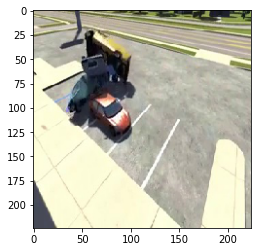

In [0]:
plt.imshow(X_test[200])

In [0]:
Y_test[200]

1

# **IMPLEMENTACIÓN MODELOS**

In [0]:
# --------------------------- REMOVIENDO ÚLTIMA CAPA DENSA DE 1000 neuronas por 3 capas densas y la última de 2 neuronas  --------------------------- 
for capa in modeloVGG16.layers:
  capa.trainable = False

x = modeloVGG16.layers[-2].output

#Agregando capas densas
x = tf.keras.layers.Dense(512, activation= "relu")(x)
x = tf.keras.layers.Dense(256, activation= "relu")(x)
x = tf.keras.layers.Dense(2, activation= 'softmax')(x)

#Generando el modelo de transfer learning
modelo_transfer_VGG16 = tf.keras.Model(modeloVGG16.input, x)

modelo_transfer_VGG16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
opt = keras.optimizers.SGD(lr=0.001, momentum=0.95)
modelo_transfer_VGG16.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [0]:
historyVGG = modelo_transfer_VGG16.fit(X_train, Y_train, epochs=8, batch_size=8,
                    validation_data=(X_test, Y_test))

Epoch 1/8
261/261 [==============================] - 17s 64ms/step - loss: 0.5707 - accuracy: 0.6900 - val_loss: 1.0699 - val_accuracy: 0.5000
Epoch 2/8
261/261 [==============================] - 16s 63ms/step - loss: 0.2786 - accuracy: 0.8690 - val_loss: 1.2837 - val_accuracy: 0.5101
Epoch 3/8
261/261 [==============================] - 16s 62ms/step - loss: 0.3259 - accuracy: 0.8839 - val_loss: 1.3142 - val_accuracy: 0.4908
Epoch 4/8
261/261 [==============================] - 16s 62ms/step - loss: 0.0453 - accuracy: 0.9923 - val_loss: 2.7298 - val_accuracy: 0.4207
Epoch 5/8
261/261 [==============================] - 16s 62ms/step - loss: 0.1969 - accuracy: 0.9395 - val_loss: 1.7518 - val_accuracy: 0.4926
Epoch 6/8
261/261 [==============================] - 16s 62ms/step - loss: 0.0597 - accuracy: 0.9779 - val_loss: 3.1501 - val_accuracy: 0.4493
Epoch 7/8
261/261 [==============================] - 16s 62ms/step - loss: 0.1243 - accuracy: 0.9669 - val_loss: 2.3248 - val_accuracy: 0.4640

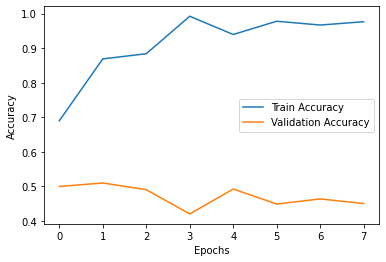

In [0]:
plt.plot(historyVGG.history['accuracy'], label='Train Accuracy')
plt.plot(historyVGG.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [0]:
# --------------------------- MODELO MOBILE NET ----------------------- 
gc.collect()

modeloMobile = tf.keras.applications.MobileNetV2( weights= "imagenet")
modeloMobile.summary()

14540800/14536120 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________

In [0]:
# ---------------------------REMOVIENDO ÚLTIMA CAPA DENSA DE 1000 neuronas por 3 capas densas y la última de 2 neuronas  -----------------------

for capa in modeloMobile.layers:
  capa.trainable = False

y = modeloMobile.layers[-2].output

#Agregando capas densas
y = tf.keras.layers.Dense(512, activation= "relu")(y)
y = tf.keras.layers.Dense(256, activation= "relu")(y)
y = tf.keras.layers.Dense(2, activation= 'softmax')(y)

#Generando el modelo de transfer learning
modelo_transfer_Mobile = tf.keras.Model(modeloMobile.input, y)

modelo_transfer_Mobile.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
opt2 = keras.optimizers.SGD(lr=0.001, momentum=0.95)
modelo_transfer_Mobile.compile(optimizer=opt2, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [0]:
historyMobile = modelo_transfer_Mobile.fit(X_train, Y_train, epochs=8, batch_size=8,
                    validation_data=(X_test, Y_test))

gc.collect()

Epoch 1/8
261/261 [==============================] - 6s 23ms/step - loss: 0.0653 - accuracy: 0.9750 - val_loss: 1.6580 - val_accuracy: 0.4737
Epoch 2/8
261/261 [==============================] - 5s 21ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.7313 - val_accuracy: 0.4742
Epoch 3/8
261/261 [==============================] - 5s 21ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.8258 - val_accuracy: 0.4705
Epoch 4/8
261/261 [==============================] - 5s 20ms/step - loss: 7.0219e-04 - accuracy: 1.0000 - val_loss: 1.9529 - val_accuracy: 0.4742
Epoch 5/8
261/261 [==============================] - 5s 21ms/step - loss: 5.3132e-04 - accuracy: 1.0000 - val_loss: 1.9941 - val_accuracy: 0.4760
Epoch 6/8
261/261 [==============================] - 5s 21ms/step - loss: 4.2655e-04 - accuracy: 1.0000 - val_loss: 2.0192 - val_accuracy: 0.4760
Epoch 7/8
261/261 [==============================] - 5s 21ms/step - loss: 3.5442e-04 - accuracy: 1.0000 - val_loss: 2.0463 - val_accurac

4750

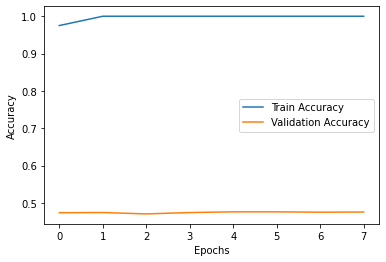

In [0]:
plt.plot(historyMobile.history['accuracy'], label='Train Accuracy')
plt.plot(historyMobile.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [0]:
# -------------------------------------------------- MODELO INCEPTIONV3  ---------------------------------------------------------------------

modeloInception = tf.keras.applications.InceptionV3(weights = "imagenet")
modeloInception.summary()

96116736/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

In [0]:
# ---------------------------REMOVIENDO ÚLTIMA CAPA DENSA DE 1000 neuronas por 3 capas densas y la última de 2 neuronas  -----------------------

for capa in modeloInception.layers:
  capa.trainable = False

z = modeloInception.layers[-2].output

#Agregando capas densas
z = tf.keras.layers.Dense(512, activation= "relu")(z)
z = tf.keras.layers.Dense(256, activation= "relu")(z)
z = tf.keras.layers.Dense(2, activation= 'softmax')(z)

#Generando el modelo de transfer learning
modelo_transfer_Inception = tf.keras.Model(modeloInception.input, z)

modelo_transfer_Inception.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [0]:
gc.collect()

opt3 = keras.optimizers.SGD(lr=0.001, momentum=0.95)
modelo_transfer_Inception.compile(optimizer=opt3, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [0]:
historyInception = modelo_transfer_Inception.fit(X_train, Y_train, epochs=8, batch_size=8,
                    validation_data=(X_test, Y_test))

Epoch 1/8
261/261 [==============================] - 14s 55ms/step - loss: 0.0959 - accuracy: 0.9640 - val_loss: 1.7835 - val_accuracy: 0.5867
Epoch 2/8
261/261 [==============================] - 13s 49ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.8782 - val_accuracy: 0.5849
Epoch 3/8
261/261 [==============================] - 13s 50ms/step - loss: 9.8472e-04 - accuracy: 1.0000 - val_loss: 1.8964 - val_accuracy: 0.5830
Epoch 4/8
261/261 [==============================] - 13s 50ms/step - loss: 6.6519e-04 - accuracy: 1.0000 - val_loss: 1.9924 - val_accuracy: 0.5858
Epoch 5/8
261/261 [==============================] - 13s 49ms/step - loss: 5.0933e-04 - accuracy: 1.0000 - val_loss: 2.0113 - val_accuracy: 0.5839
Epoch 6/8
261/261 [==============================] - 13s 49ms/step - loss: 4.1240e-04 - accuracy: 1.0000 - val_loss: 2.0931 - val_accuracy: 0.5867
Epoch 7/8
261/261 [==============================] - 13s 50ms/step - loss: 3.3708e-04 - accuracy: 1.0000 - val_loss: 2.0662 - 

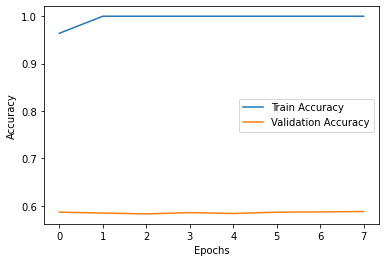

In [0]:
plt.plot(historyInception.history['accuracy'], label='Train Accuracy')
plt.plot(historyInception.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [0]:
# -------------------------------------------------- MODELO RESNET 101 ---------------------------------------------------------------------

modeloResnet = tf.keras.applications.ResNet101V2(weights="imagenet")
modeloResnet.summary()

179519488/179518384 [==============================] - 2s 0us/step
Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_____________________

In [0]:
for capa in modeloResnet.layers:
  capa.trainable = False

w = modeloResnet.layers[-2].output

#Agregando capas densas
w = tf.keras.layers.Dense(512, activation= "relu")(w)
w = tf.keras.layers.Dense(256, activation= "relu")(w)
w = tf.keras.layers.Dense(2, activation= 'softmax')(w)

#Generando el modelo de transfer learning
modelo_transfer_Resnet = tf.keras.Model(modeloResnet.input, w)

modelo_transfer_Resnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
gc.collect()

opt4 = keras.optimizers.SGD(lr=0.001, momentum=0.95)
modelo_transfer_Resnet.compile(optimizer=opt4, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [0]:
historyResnet = modelo_transfer_Resnet.fit(X_train, Y_train, epochs=8, batch_size=8,
                    validation_data=(X_test, Y_test))

Epoch 1/8
261/261 [==============================] - 20s 76ms/step - loss: 0.0555 - accuracy: 0.9774 - val_loss: 1.5764 - val_accuracy: 0.5964
Epoch 2/8
261/261 [==============================] - 18s 70ms/step - loss: 8.4441e-04 - accuracy: 1.0000 - val_loss: 1.7134 - val_accuracy: 0.5923
Epoch 3/8
261/261 [==============================] - 18s 70ms/step - loss: 5.2529e-04 - accuracy: 1.0000 - val_loss: 1.8477 - val_accuracy: 0.5918
Epoch 4/8
261/261 [==============================] - 18s 70ms/step - loss: 3.9225e-04 - accuracy: 1.0000 - val_loss: 1.8478 - val_accuracy: 0.5904
Epoch 5/8
261/261 [==============================] - 18s 70ms/step - loss: 3.1280e-04 - accuracy: 1.0000 - val_loss: 1.8976 - val_accuracy: 0.5895
Epoch 6/8
261/261 [==============================] - 18s 70ms/step - loss: 2.5825e-04 - accuracy: 1.0000 - val_loss: 1.9651 - val_accuracy: 0.5899
Epoch 7/8
261/261 [==============================] - 18s 69ms/step - loss: 2.2073e-04 - accuracy: 1.0000 - val_loss: 1.992

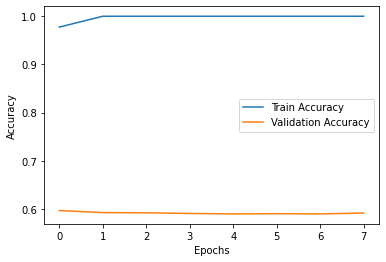

In [0]:
plt.plot(historyResnet.history['accuracy'], label='Train Accuracy')
plt.plot(historyResnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [0]:
modeloXCeption = tf.keras.applications.Xception(weights="imagenet")

for capa in modeloXCeption.layers:
  capa.trainable = False

w = modeloXCeption.layers[-2].output

#Agregando capas densas
w = tf.keras.layers.Dense(512, activation= "relu")(w)
w = tf.keras.layers.Dense(256, activation= "relu")(w)
w = tf.keras.layers.Dense(2, activation= 'softmax')(w)

#Generando el modelo de transfer learning
modelo_transfer_XCeption = tf.keras.Model(modeloXCeption.input, w)

modelo_transfer_XCeption.summary()

91889664/91884032 [==============================] - 3s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________

In [0]:
opt5 = keras.optimizers.SGD(lr=0.001, momentum=0.95)
modelo_transfer_XCeption.compile(optimizer=opt5, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [0]:
historyXCeption = modelo_transfer_XCeption.fit(X_train, Y_train, epochs=8, batch_size=8,
                    validation_data=(X_test, Y_test))

Epoch 1/8
261/261 [==============================] - 14s 55ms/step - loss: 0.1476 - accuracy: 0.9472 - val_loss: 1.0506 - val_accuracy: 0.5544
Epoch 2/8
261/261 [==============================] - 14s 52ms/step - loss: 0.0078 - accuracy: 0.9995 - val_loss: 1.2108 - val_accuracy: 0.5480
Epoch 3/8
261/261 [==============================] - 14s 52ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.1869 - val_accuracy: 0.5701
Epoch 4/8
261/261 [==============================] - 14s 52ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.3084 - val_accuracy: 0.5558
Epoch 5/8
261/261 [==============================] - 14s 52ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.3286 - val_accuracy: 0.5577
Epoch 6/8
261/261 [==============================] - 14s 52ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.3887 - val_accuracy: 0.5544
Epoch 7/8
261/261 [==============================] - 14s 52ms/step - loss: 8.5756e-04 - accuracy: 1.0000 - val_loss: 1.4582 - val_accuracy: 0.

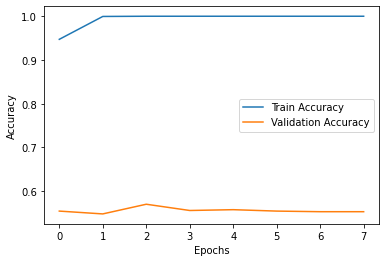

In [0]:
plt.plot(historyXCeption.history['accuracy'], label='Train Accuracy')
plt.plot(historyXCeption.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()